In [1]:
# Install required libs
#!pip install -U segmentation-models-pytorch albumentations --user 

In [2]:
#!pip uninstall -y segmentation-models-pytorch

## UNDER PROCESS !!!

## Loading data

#DATASET INFO HERE


In [8]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [11]:
DATA_DIR = 'C://Users//baran.tanriverdi//Research//.data//pollut//'

# load repo with data if it is not exists
############

In [12]:
x_train_dir = os.path.join(DATA_DIR, 'train//images//')
y_train_dir = os.path.join(DATA_DIR, 'train//masks//')

x_test_dir = os.path.join(DATA_DIR, 'test//images//')
y_test_dir = os.path.join(DATA_DIR, 'test//masks//')

In [9]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [7]:
i=0; os.path.join(x_train_dir, f"image ({i}).jpeg")

'C://Users//baran.tanriverdi//Research//.data//pollut//train//images//image (0).jpeg'

In [8]:
#os.listdir(x_train_dir)

In [9]:
from tqdm import tqdm
# preparing data.
class Dataset():
    IMG_SIZE = 64
    image_dir = x_train_dir
    mask_dir = y_train_dir
    x_data = []
    y_data = []

    imcount = 0

    def make_data(self):
        for i in tqdm(range(len(os.listdir(self.image_dir)))):
            self.imcount +=1
            img_path, mask_path = os.path.join(self.image_dir,f"image ({self.imcount}).jpg"), os.path.join(self.mask_dir, f"mask ({self.imcount}).jpg")
            #print(img_path, mask_path)
            img, mask = cv2.imread(img_path, cv2.COLOR_BGR2RGB), cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
            img, mask = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE)), cv2.resize(mask, (self.IMG_SIZE, self.IMG_SIZE))   
            
            self.x_data.append(img); self.y_data.append(mask)
            
        np.save(os.path.join(DATA_DIR, "images"), self.x_data)
        np.save(os.path.join(DATA_DIR, "masks"), self.y_data)
        
        print('Images:', self.imcount)

In [10]:
train_dataset = Dataset()
train_dataset.make_data()


100%|██████████| 66/66 [00:17<00:00,  3.74it/s]

Images: 66


### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [11]:
# AUGMENTATION !! IGNORE THE CODE FOR NOW

#data_transform = torchvision.transforms.Resize(64, interpolation=3)

In [12]:
"""import albumentations as albu"""

'import albumentations as albu'

In [13]:
#### Visualize resulted augmented images and masks


### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [13]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset 
from torch import Tensor

In [14]:
x = np.load(os.path.join(DATA_DIR, "images.npy")) ; y = np.load(os.path.join(DATA_DIR, "masks.npy"))
            
x, y = Tensor(x) / 255.0, Tensor(y) / 255.0 

torch.Size([66, 64, 64, 3]) torch.Size([66, 64, 64])


(<AxesSubplot:>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x220e4b9de88>)

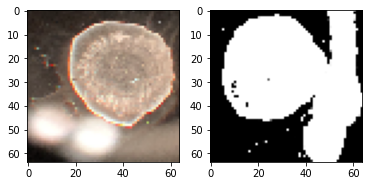

In [15]:
print(x.shape , y.shape)

plt.subplot(1,2,1), plt.imshow(x[11]), plt.subplot(1,2,2), plt.imshow(y[11], cmap= 'gray')

torch.Size([16, 64, 64, 3])
torch.Size([16, 3, 64, 64]) torch.Size([16, 1, 64, 64])


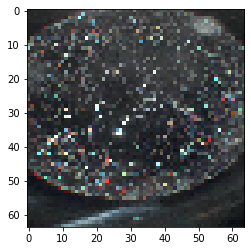

In [16]:
train_x, train_y = x[:50, :,:,:], y[:50,:,:]
val_x, val_y = x[50:, :,:,:], y[50:,:,:]

print(val_x.shape)
plt.imshow(val_x[1])


train_x, train_y = train_x.permute(0, -1, 1, 2), train_y.reshape(-1, 1, 64, 64)
val_x, val_y = val_x.permute(0, -1, 1, 2), val_y.reshape(-1, 1, 64, 64)
print(val_x.shape, val_y.shape)


torch.Size([1, 64, 64])


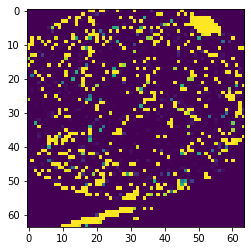

In [17]:
plt.imshow(val_y[1][0])
print(val_y[1].shape)

In [18]:
BATCH_SIZE = 4

train_Ds = TensorDataset(train_x, train_y)
train_ld = DataLoader(train_Ds , batch_size = BATCH_SIZE, shuffle=True)

valid_Ds = TensorDataset(val_x, val_y)
print(len(valid_Ds))
valid_ld = DataLoader(valid_Ds, batch_size = 1)


16


## Create model and train

In [19]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [20]:
#help(smp.Unet)

In [21]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = None
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cpu'

# create segmentation model
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    in_channels = 3,
    classes=1, 
    activation=ACTIVATION,
    decoder_use_batchnorm = True
)

#preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [51]:
#model

In [22]:
inin = val_x[1].unsqueeze(0)
inin.shape
outout = model(inin)
outout.shape

torch.Size([1, 1, 64, 64])

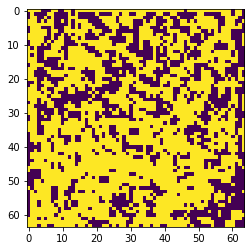

In [23]:
outout = (outout.squeeze().detach().numpy().round())
plt.imshow(outout)

In [24]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [25]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples

DEVICE = 'cpu'
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [26]:
#help(smp.utils.metrics.IoU)

In [27]:
# train model for __ epochs

max_score = 0

EPOCHS_NUM = 40
with open("mod.log", "a") as f:
    for i in range(0, EPOCHS_NUM):

        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_ld)
        valid_logs = valid_epoch.run(valid_ld)
        f.write(f"\n {i}," 
                 f"{train_logs['dice_loss']}, {train_logs['iou_score']}," 
                 f"{valid_logs['dice_loss']}, {valid_logs['iou_score']}")
        # do something (save model, change lr, etc.)
        if max_score < valid_logs['iou_score']:
            max_score = valid_logs['iou_score']
            torch.save(model, '.models/best_unet_model.pth')
            print('Model saved!')

        if i == 25:
            optimizer.param_groups[0]['lr'] = 1e-5
            print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 16/16 [00:00<00:00, 18.76it/s, dice_loss - 0.5934, iou_score - 0.377] 
Model saved!

Epoch: 1
valid: 100%|██████████| 16/16 [00:00<00:00, 16.79it/s, dice_loss - 0.5234, iou_score - 0.4307]
Model saved!

Epoch: 2
valid: 100%|██████████| 16/16 [00:00<00:00, 19.52it/s, dice_loss - 0.4833, iou_score - 0.4353]
Model saved!

Epoch: 3
valid: 100%|██████████| 16/16 [00:00<00:00, 19.50it/s, dice_loss - 0.4686, iou_score - 0.4535]
Model saved!

Epoch: 4
valid: 100%|██████████| 16/16 [00:00<00:00, 18.30it/s, dice_loss - 0.4704, iou_score - 0.443] 

Epoch: 5
valid: 100%|██████████| 16/16 [00:00<00:00, 16.34it/s, dice_loss - 0.4602, iou_score - 0.4485]

Epoch: 6
valid: 100%|██████████| 16/16 [00:00<00:00, 18.48it/s, dice_loss - 0.4566, iou_score - 0.4426]

Epoch: 7
valid: 100%|██████████| 16/16 [00:00<00:00, 19.38it/s, dice_loss - 0.4547, iou_score - 0.4469]

Epoch: 8
valid: 100%|██████████| 16/16 [00:00<00:00, 19.14it/s, dice_loss - 0.4438, iou_score - 0.4621]
Mod

## ERROR ANALYSIS


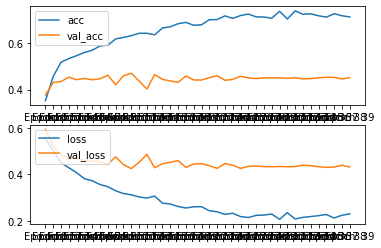

In [31]:
def create_acc_loss_graph():
    contents = open("mod.log", "r").read().split("\n")

    epochs = []
    ious = []
    losses = []

    val_ious = []
    val_losses = []

    for c in contents:
        epoch, loss, iou, val_loss, val_iou = c.split(",")

        epochs.append(int(epoch))
        ious.append(float(iou))
        losses.append(float(loss))

        val_ious.append(float(val_iou))
        val_losses.append(float(val_loss))

    fig = plt.figure()

    ax1 = plt.subplot2grid((2, 1), (0, 0))
    ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)

    ax1.plot(epochs, ious, label="acc")
    ax1.plot(epochs, val_ious, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(epochs, losses, label="loss")
    ax2.plot(epochs, val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()
    

create_acc_loss_graph()


## Test best saved model

In [32]:
# load best saved checkpoint
torch.save(model, '.models/best_unet_model.pth')
print('Model saved!')

best_model = torch.load('.models/best_unet_model.pth')

Model saved!


In [33]:

from tqdm import tqdm
# preparing data.
class Dataset():
    IMG_SIZE = 64
    image_dir = x_test_dir
    mask_dir = y_test_dir
    x_data = []
    y_data = []

    imcount = 0

    def make_data(self):
        for i in tqdm(range(len(os.listdir(self.image_dir)))):
            self.imcount +=1
            img_path, mask_path = os.path.join(self.image_dir,f"image ({self.imcount}).jpg"), os.path.join(self.mask_dir, f"mask ({self.imcount}).jpg")
            #print(img_path, mask_path)
            img, mask = cv2.imread(img_path, cv2.COLOR_BGR2RGB), cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
            img, mask = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE)), cv2.resize(mask, (self.IMG_SIZE, self.IMG_SIZE))   
            
            self.x_data.append(img); self.y_data.append(mask)
            
        np.save(os.path.join(DATA_DIR, "t_images"), self.x_data)
        np.save(os.path.join(DATA_DIR, "t_masks"), self.y_data)
        
        print('Images:', self.imcount)


# create test dataset
test_dataset = Dataset()
test_dataset.make_data()

100%|██████████| 16/16 [00:03<00:00,  5.19it/s]

Images: 16


In [41]:
test_x = np.load(os.path.join(DATA_DIR, "t_images.npy")) ; test_y = np.load(os.path.join(DATA_DIR, "t_masks.npy"))
            
test_x, test_y = Tensor(test_x) / 255.0, Tensor(test_y) / 255.0 

In [42]:
test_x, test_y = test_x.permute(0, -1, 1, 2), test_y.reshape(-1, 1, 64, 64)
print(test_x.shape)
test_Ds = TensorDataset(test_x, test_y)
print(len(test_Ds))
test_ld = DataLoader(test_Ds, batch_size = BATCH_SIZE)


torch.Size([16, 3, 64, 64])
16


In [43]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_ld)

valid: 100%|██████████| 4/4 [00:00<00:00,  8.75it/s, dice_loss - 0.3332, iou_score - 0.5449]


## Visualize predictions

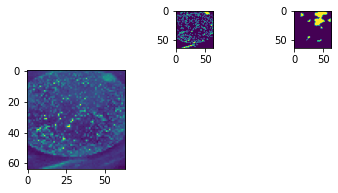

In [44]:

image, gt_mask = val_x[1], val_y[1]
#print(image.shape)
gt_mask = gt_mask.squeeze()
#print(gt_mask.shape)
x_tensor = image.unsqueeze(0)
 #print(x_tensor.shape)
pr_mask = best_model.predict(x_tensor)
pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    
plt.subplot(1, 3, 1)
plt.imshow(image[0])
    
plt.subplot(5, 3, 2)
plt.imshow(gt_mask)
    
plt.subplot(5, 3, 3)
plt.imshow(pr_mask)
